# **MWE of community assembly**

## **Context**

1. **Project background**：
This project is part of a big new program titled ‘A new Green Revolution: Manipulating the soil microbiome to enhance the sustainability of 21st century agriculture,’. The current focus is to optimise/engineer soil microbiomes to suppress the fungus Gaeumannomyces tritici, which causes the **take-all disease** in wheat (T. aestivum).

2. **Microbial community coalescence**：
It is the process by which two distinct microbial communities encounter one another and interact to form a new ‘daughter’ community. This assemblage may more closely resemble one ‘parent’ community than the other, and its functional profile may be totally unique. We plan to use a coalescence method to ensure resistant community is intact in order to carry out its desired function in soil.


## **Obectives**

**Can we predict winners and losers during coalescence?**

This very basic question remains relatively un-explored. However, we did have some insights on community assembly. That is, species with higher CUE value tend to survive. And there is certain connection between species richness and CUE variance.

We will use the similiar methdology as community assembly to simulate the community dynamics during coalescence, mediated by temperature. By doing that, we hope to predict the result of community coalescence through carbon usage efficiency appearance of species in different temperature. The outcome of this research will give some foundamental information for the coalescence experiments and the dealing with take-all disease project.

**Microbial Consumer Resource Model**

$$
\frac{dC_i}{dt} = \sum_{\alpha=0}^{M} C_i R_{\alpha} u_{i\alpha} (1 - \lambda_{\alpha}) - C_i m_i
$$

$$
\frac{dR_{\alpha}}{dt} = \rho_{\alpha} - R_{\alpha} \omega_{\alpha} - \sum_{i=0}^{N} C_i R_{\alpha} u_{i\alpha} + \sum_{i=0}^{N} \sum_{\beta=0}^{M} C_i R_{\beta} u_{i\beta} l_{i\beta\alpha}
$$


| **Parameter** | **Description** | **Key** |
|--------------|---------------|--------|
| $C_i$ | Biomass of the $i$th consumer | - |
| $R_{\alpha}$ | Mass of the $\alpha$th resource | - |
| $N$ | Number of consumer populations | $N$ |
| $M$ | Number of resources | $M$ |
| $u_{i\alpha}$ | Uptake rate of the $\alpha$th resource by the $i$th consumer | $u$ |
| $m_i$ | Loss term for the $i$th consumer | $m$ |
| $\rho_{\alpha}$ | Inflow rate for the $\alpha$th resource | $\rho$ |
| $\omega_{\alpha}$ | Outflow term for the $j$th resource | $\omega$ |
| $l_{i\alpha\beta}$ | Proportion of uptake of the $\alpha$th resource leaked to the $\beta$th resource by $i$th consumer | $l$ |
| $\lambda_{\alpha}$ | Total proportion of the $\alpha$th resource leaked, same as $\sum_{\beta} l_{\alpha\beta}$ | $\lambda$ |


We adapt this model because it is able to capture the complex interactions of both competition for resources and the exchange of metabolic by-products.

## **Simulation:**

Import the packages

In [1]:
using Pkg
Pkg.activate("../packages")

  Activating project at `~/Documents/MiCRM/packages`


create an independent environment to avoid the conflicts

In [2]:
using Distributions

`Distributions` is a package for probability distributions and associated functions. We need it to use dirichlet distribution for uptake matrix and leakage matrix

In [3]:
using MiCRM

`MiCRM` is the package for simulation of Microbial Consumer Resource (MiCRM) systems. It countains some aggregated functions.

Now we  *set system size and leakage rate*

In [4]:
N,M,leakage = 100,50,0.3

(100, 50, 0.3)

N is the **number of species in a community**, M is the **number of resource types**, leakage is the overall leakage rate

Next, *make uptake matrix out of dirichlet distribution*

In [5]:
u =  MiCRM.Parameters.modular_uptake(M,N; N_modules = 10, s_ratio = 3.0)

50×100 Matrix{Float64}:
 0.0206918    0.0342277    0.0330921    …  0.016666     0.00957241
 0.0152135    0.040786     0.0303689       0.00185816   0.000633976
 0.0258487    0.027282     0.000757528     0.00782771   0.00267522
 0.0315424    0.0440615    0.00732708      0.00727501   0.00368172
 0.0230803    0.0019709    0.0303568       0.00549155   0.0145302
 0.00055246   0.0133448    0.0133709    …  0.0159111    0.00160129
 0.00223308   0.00429224   0.0103028       0.0142863    0.0134669
 0.013744     0.0112783    0.00162535      0.00811009   0.00131364
 0.000666603  0.00299768   0.00240614      0.0100451    0.00448123
 0.0153696    0.00691429   0.0114334       0.0127884    0.0143025
 0.00859044   0.0104576    0.0064517    …  0.00846924   0.0110233
 0.0011135    0.016285     0.00433367      0.0140958    0.0102682
 0.00877488   0.000749798  0.00220473      0.00982975   0.00357798
 ⋮                                      ⋱               
 0.00459033   0.0123833    0.00849258      0.0050877

The N_modules determines how many different blocks of resources will be divided into, and s_ratio determines how much will species focus on inner group resources. *More details about this function see document of functions

*Define other terms*

In [6]:
#Loss term
m = 0.05 *ones(N)

100-element Vector{Float64}:
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 ⋮
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05
 0.05

m is a loss term for the the consumers. It can be simply understood as the proportion of deceased organisms.

In [7]:
#resource inflow + outflow
ρ = ones(M)
ω = 0.03 * ones(N)

100-element Vector{Float64}:
 0.03
 0.03
 0.03
 0.03
 0.03
 0.03
 0.03
 0.03
 0.03
 0.03
 0.03
 0.03
 0.03
 ⋮
 0.03
 0.03
 0.03
 0.03
 0.03
 0.03
 0.03
 0.03
 0.03
 0.03
 0.03
 0.03

ρ is the resource inflow amount of the system and ω is outflow rate.

Next, we *make leakage matrix out of dirichlet distribution and make it modular*

In [8]:
    leakage_matrices = []

    for _ in 1:100
        l = MiCRM.Parameters.modular_leakage(M; N_modules=5, s_ratio=2.0, λ=leakage)
        push!(leakage_matrices, l)  
    end

We make it N times to generate a unique resource leakage matrix for each consumer. Similarly to the `MiCRM.Parameters.modular_uptake`, the N_modules determines how many the different blocks of resources will be divided into, and s_ratio determines the structure of leakage.

In [9]:
#define parameters
param = MiCRM.Parameters.generate_params(N, M;  u = u, m = m, ρ = ρ, ω = ω, l = leakage_matrices, λ = leakage)

(N = 100, M = 50, u = [0.0054038768460349254 0.016894602799430593 … 0.029322128071171398 0.07279005571302262; 0.006177420028563642 0.06204882024727073 … 0.021633991698784244 0.005313382302409032; … ; 0.012126546194822983 0.007815525893249216 … 0.02255895005165174 0.0015016841132291306; 0.03684748295091023 0.01084124101632272 … 0.009351579960452782 0.022192338998753936], m = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], ρ = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], ω = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], l = [0.001581056746731212 0.0018502241747841142 … 0.010916965732431934 0.0110584782604349; 0.007880004323572368 0.002734654764055816 … 0.004424202797842367 0.012604001048744786; … ; 0.0005894895808902333 0.0016623313081442724 … 0.010167431343215804 0.004525872528403907; 0.0016184172714095088 0.00248

We use this function to aggregate the parameters of the system. If only with N, M, and λ, this function will help generate other parameters by default (randomly).

For now, we finished the parameter part and it is time to create an **Ordinary Differential Equation Problem** object which defines the problem for the ODE solver and then solve it with the aptly solve function.
To define the ODEProblem we need to specify the initial state of the system as well as the timespan

In [10]:
#original state
x0 = ones(N+M)

150-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

x0 is an initial state, a one-dimensional array (vector) of length N+M, where all elements are initialized to 1.  

In [11]:
#time span
tspan = (0.0, 10.0)

(0.0, 10.0)

The initial time is 0.0 and the final time is 10.0

In [12]:
#define problem
using DifferentialEquations
prob = ODEProblem(MiCRM.Simulations.dx!, x0, tspan, param)

┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase ~/.julia/packages/SciMLBase/Pma4a/src/performance_warnings.jl:33


ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 150-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

We import the `DifferentialEquations.jl` package, which provides tools for solving differential equations.  
`MiCRM.Simulations.dx!` function is a derivative function for the general MICRM model. This function is used internally by the DiffEq solver.


In [13]:
sol = solve(prob, Tsit5())

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 17-element Vector{Float64}:
  0.0
  0.08403304643830245
  0.22349855250084819
  0.39077405385003455
  0.6088886192865799
  0.8744926139754938
  1.2069308334504034
  1.612444591895692
  2.1063189583199864
  2.6925601007778073
  3.385122470828113
  4.1994283013841756
  5.161014307852848
  6.302891795846881
  7.663948597784522
  9.24782148877318
 10.0
u: 17-element Vector{Vector{Float64}}:
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
 [0.9719365027203233, 0.9720107338515956, 0.9719991845631787, 0.9720318931629134, 0.9719148062332706, 0.9719783695450204, 0.9719981418868054, 0.9720321578293138, 0.9719680935188041, 0.9720296839096342  …  0.8936404998241125, 0.9211149945972594, 0.90816700678191, 0.9297081191407979, 0.8955531564610331, 0.8813358122555686, 0.896049787198874, 0.8595406599964696, 0.9007505909671314, 0.8730237432764398]
 [0.9162693171903208, 0.9

In this case, we use Tsit5 as a solver, which is widely applicable for non-stiff problems. Non -stiff means the system evolves smoothly without sudden, rapid variations in different components.
If need more information about the solver choice, refer to https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/

At last, we *calculate key properties* to test whether the system is stable

In [14]:
# jacobian of system from the solution object
J = MiCRM.Analysis.get_jac(sol)

150×150 Matrix{Float64}:
 -0.319355      0.0           0.0         …   0.000280437   0.000696165
  0.0          -0.31892       0.0             0.000211132   5.18548e-5
  0.0           0.0          -0.318979        0.000222293   0.000353423
  0.0           0.0           0.0             8.84661e-5    0.000368438
  0.0           0.0           0.0             0.00013066    0.000136618
  0.0           0.0           0.0         …   0.00010924    0.000587266
  0.0           0.0           0.0             0.000176859   0.000187412
  0.0           0.0           0.0             0.000134      0.000180607
  0.0           0.0           0.0             0.000356564   0.000383281
  0.0           0.0           0.0             3.90315e-5    6.83947e-5
  0.0           0.0           0.0         …   0.000301601   0.000208473
  0.0           0.0           0.0             4.17005e-5    0.00025496
  0.0           0.0           0.0             0.000102142   3.4551e-5
  ⋮                                       ⋱ 

`MiCRM.Analysis.get_jac(sol)` numerically calculate jacobian of system from the solution object. The Jacobian matrix (J) is a matrix of partial derivatives that represents the local linearization of a system of differential equations. 

In [15]:
# generate purbulence matrix
pur = rand(size(J, 1))

150-element Vector{Float64}:
 0.3809600214684943
 0.9772030794000587
 0.3162190726809957
 0.2593535150379993
 0.0435708875182661
 0.6570967345037559
 0.054672797138082596
 0.39877177717044854
 0.41355420431444023
 0.9169245822350309
 0.3704224896072974
 0.9701241914386102
 0.41421470641975233
 ⋮
 0.49185466009183887
 0.590538267017017
 0.13944274880475938
 0.480677333547222
 0.28653305900970283
 0.48091589283418923
 0.3225992747356381
 0.13930908226458805
 0.039698303537223034
 0.99731591777747
 0.3427966733328014
 0.33868951510348133

Generates a random vector with a length equal to the number of rows in J, with each element sampled from a uniform distribution between 0 and 1, which will be used to perturb the system for sensitivity or stability analysis

In [16]:
# the instantaneous rate of growth of the perturbation pur at time t.
t = 5
MiCRM.Analysis.get_Rins(J, pur, t)

-0.31457306184804595

This function computes Instantaneous Resilience (Rins), which measures the instantaneous rate of growth of the perturbation. If there is a positive value, that means the perturbation is growing, therefore the system is locally unstable. If it is negative, then the perturbation is shrinking and the system is stable

In [17]:
# Determine the stability a system
MiCRM.Analysis.get_stability(J)

true

Determine the stability a system given its jaccobian by testing if the real part of the leading eigenvalue is positive. It will return a boolean value.

In [18]:
#test whether a system is reactive to the perturbation 
MiCRM.Analysis.get_reactivity(J,pur)

false

Test wether the system is "reactive" to the perturbation u. A reactive is system is one where the initial perturbation is amplified so that the deviation from equilibrium initially increases. It will also return a boolean value.

In [19]:
#get the rate of return of the system from perturbation
MiCRM.Analysis.get_return_rate(J)

-0.318594184542638

Get the rate of return of the system from perturbation. This value is determined by the leading eigenvalue regardless of the direction of the perturbation or the observation vector we choose. Positive means that after a perturbation, the system will quickly return to its equilibrium state; negative means that the system wouldn't be able to return to equilibrium.

## **Visualization**

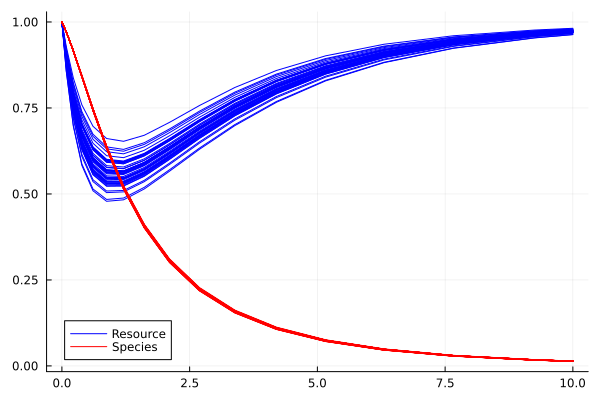

In [20]:
using Plots

   sol_u = reduce(hcat, sol.u) 

   plot(sol.t, sol_u[N+1:end, :]', color=:blue, label=false)
   plot!(sol.t, sol_u[1:N, :]', color=:red, label=false) 
   
   plot!([NaN], color=:blue, label="Resource")
   plot!([NaN], color=:red, label="Species")
   

Figure 1: Dynamics of consumers and resources. It displays how population of species and amount of resources change in a system

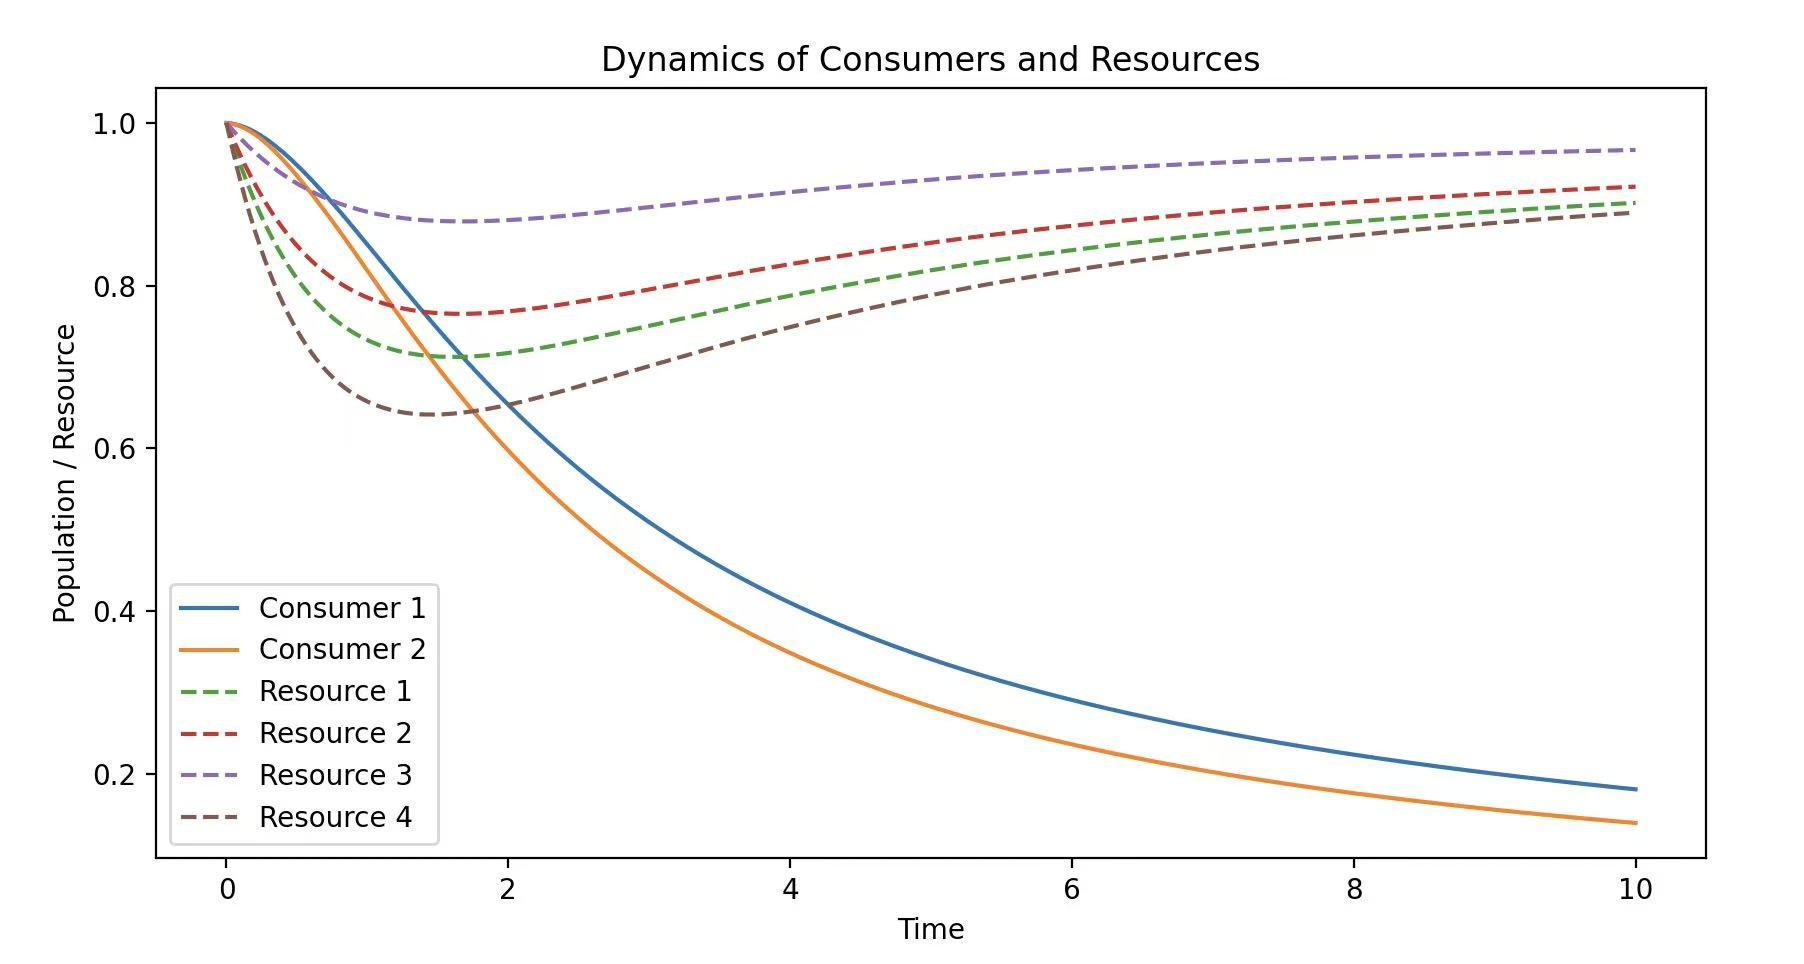

## **Outputs and next step**

Outputs: an assembled stable community, with the information of each species' resource uptake rate and leakage rate  
Next step: coalescence. We plan to make two stable community respectively and give the traits of these two community to model as input to go through simulation for coalescence.  
One current problem is how to bond these two community together.

## **Documents of functions**

**MiCRM.Parameters.modular_uptake**  
`MiCRM.Parameters.modular_uptake(M,N; N_modules = 2, s_ratio = 10.0)`  
It helps generate an uptake matrix using a Dirichlet distribution such that the uptake of all consumers sums to 1.
The number of modules determines how many groups of resources the consumers are specialised over. For example if N_modules = 2 then the resources will be split into two groups with half the consumers specialising on one and half on the other.

The degree of specialisation is determined by the s_ratio value. This controls the relative value of the dirchlet α parameters which determine how the probabiltiy density function is distributed over the different resources. Specialisation is obtained by setting the α values for resources that specialists consume to higher values meaning they have a higher probablity of a larger value. When s_ratio = 1 the proabailtiy is uniform and all resources are equally likely to be consumed. When s_ratio >1 then consumers are more likely to consume resources within thier module.

**MiCRM.Parameters.modular_leakage**  
```MiCRM.Parameters.modular_leakage(M; N_modules = 2, s_ratio = 10.0, λ = leakage)```  
It generates a modular leakage matrix with a directional leakage structure. The matrix is generated using a Dirichlet distribution such that the leakage of all resources sums to λ.

The number of modules determines how many groups of resources they are split into. For example if N_modules = 5 then the resources will be split into five groups with the first group of resources tending to leak to the second, the second to the third and so on.

The degree of to which resources leak in this constrained way (verses randomly across all resources) is determined by the s_ratio value. This controls the relative value of the dirchlet α parameters which determine how the probabiltiy density function is distributed over the different resources. A greater probabiltiy of leakage from one resource to another is obtained by setting the α values for resources to higher values. When s_ratio = 1 the proabailtiy is uniform and all resources are equally likely to be leaked to each other. When s_ratio >1 then resources are more likely to leak to resources thier own or the next module in the sequence.

**MiCRM.Parameters.generate_params**  
```MiCRM.Parameters.generate_params(N, M;  u = u, m = m, ρ = ρ, ω = ω, l = l, λ = leakage)```  
It generates parameter sets for MiCRM simualtions. Requires the system size is defined as well as the functions to generate the actual parameters used in the simulations. Extra arguments can also be passed via the kwargs argument.By default the function generates a random MiCRM system with no structure and uptake and leakage matricies generated by Dirichlet distribitions.

The function returns a NamedTuple with all the parameters as well as a kw entry which itself is a NamedTuple with the additional arguments provided.